# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00


2. Load the data from the hub.

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split='aira_instruct_portuguese')

df = dataset.to_pandas()
df = df.sample(frac=1)
df = df.reset_index(drop=True)

display(df)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating aira_english split:   0%|          | 0/9183 [00:00<?, ? examples/s]

Generating aira_instruct_english split:   0%|          | 0/48666 [00:00<?, ? examples/s]

Generating aira_instruct_portuguese split:   0%|          | 0/48571 [00:00<?, ? examples/s]

Generating aira_portuguese split:   0%|          | 0/9204 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-4077fd700c38fc36/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


prompt  \
0      Quem foram alguns dos compositores mais influe...   
1      Quais etapas devo seguir para construir um lag...   
2      Todos os indivíduos de ascendência asiática sã...   
3      Que tipo de atividades posso fazer para reduzi...   
4         Como posso me tornar um orador público eficaz.   
...                                                  ...   
48566  Quais são as melhores maneiras de se exercitar...   
48567  Você pode me contar um pouco sobre a história ...   
48568          Como consertar o alternador do meu carro.   
48569  Preciso de ajuda para escolher o melhor forno ...   
48570  O custo de vida é mais alto em Los Angeles ou ...   

                                              completion  
0      Resposta: Alguns dos compositores mais influen...  
1      Selecione um local adequado para o seu lago, n...  
2      É injusto e incorreto fazer uma afirmação abra...  
3      Exercite-se, como correr, nadar, praticar ioga...  
4      Para se tornar um orador público eficaz, comec...  
...                                                  ...  
48566  Aproveite os exercícios de peso corporal - ele...  
48567  A AIRES (AI Robotics Ethics Society) visa educ...  
48568  Para consertar o alternador do seu carro, você...  
48569  Encontrar o melhor forno para o seu espaço dep...  
48570  O custo de vida em Los Angeles é geralmente ma...  

[48571 rows x 2 columns]

3. Load `BloomTokenizerFast` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [ ]:
from transformers import BloomTokenizerFast

model_name = "bloom-1b7"
model_size = "1B7"

tokenizer = BloomTokenizerFast.from_pretrained(f"bigscience/{model_name}",
    add_prefix_space=True,
    bos_token='<|startoftext|>',
    eos_token='<|endoftext|>',
    pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  48571
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [ ]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 43,713
Number of validation samples: 4,858


8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=6 # 16, 6
        )


validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=6
        )

9. Load the base model (`BloomForCausalLM`).

In [ ]:
from transformers import BloomForCausalLM, BloomConfig

configuration = BloomConfig.from_pretrained(f"bigscience/{model_name}", output_hidden_states=False)

model = BloomForCausalLM.from_pretrained(f"bigscience/{model_name}")
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250683, 2048)
    (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 6

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  24
Number of transformer blocks to un-freeze:  6
Number of frozen layers: 218
Number of trainable layers: 75


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

warmup_steps = 1e2

sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [13]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/drive/MyDrive/Colab Notebooks/Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )
tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 2



  5%|▌         | 400/7286 [07:14<2:03:48,  1.08s/it]


Batch 400 of 7286. Loss:1.017694354057312.


Example output: Qual é a melhor maneira de remover uma mancha de algodão.A melhor maneira de remover uma mancha de algodão é criar uma solução e usar uma solução de água e um produto com alvejantes. Deslize a mancha nos dentes do couro e encontre algum bom ponto de ponto. Se você não se sentir confortável usando uma solução, você pode tentar misturar uma solução de água e uma solução com um produto com vinagre. É importante usar uma solução de água em vez de vinagre para remover uma mancha de algodão. Se a mancha não estiver sólida, você pode combiná-lo com uma solução com sal.



 11%|█         | 800/7286 [14:29<1:56:35,  1.08s/it]


Batch 800 of 7286. Loss:0.7983549237251282.


Example output: Qual é a maneira mais eficiente de limpar a geladeira.A maneira mais eficiente de limpar a geladeira é substituir a geladeira por outras com recursos de limpeza mais eficientes. Outras medidas de conservação de energia podem ajudar a economizar energia quando forem necessárias e evitar que o armário de geladeira se torne um armário de geladeira.



 16%|█▋        | 1200/7286 [21:42<1:49:25,  1.08s/it]


Batch 1200 of 7286. Loss:1.0566221475601196.


Example output: Como me tornar mais independente e organizado.Uma maneira de se tornar mais independente e organizado é criar um plano de estudo adaptado aos seus objetivos de carreira, dividindo tarefas e dividindo tarefas em tarefas menores e mais difíceis. Priorize suas tarefas, priorize suas tarefas e concentre-se em uma tarefa e não em outras. Estabelecer lembretes específicos para suas prazos e gerenciar o tempo, ao desenvolver uma rotina, pode ajudar a não interromper sua rotina e não ter que se concentrar em suas tarefas, o que pode ajudá-lo a se tornar mais bem-sucedido. Além disso, estabelecer lembretes regulares com prazos específicos para o prazo do próximo mês e de uma próxima semana, além de ter uma programação do dia, ajudará a manter a mente aberta e, às vezes, a lembrar possíveis links ou conexões ao se concentrar em seus objetivos. Com planejar e decidir sobre o tipo de rotina que você seguir, você pode aproveitar ao máx

 22%|██▏       | 1600/7286 [28:59<1:42:15,  1.08s/it]


Batch 1600 of 7286. Loss:1.3944921493530273.


Example output: O que é uma boa rotina de exercícios para perda de peso.Uma boa rotina de exercícios para perda de peso é incorporar uma variedade de atividades físicas, como ioga e pilates, e incorporar atividade adequada de forma consistente, ao mesmo tempo em que você seja saudável e esteja disposto a experimentar. Tente incorporar rajadas curtas de atividade, como exercícios de baixa intensidade de baixa intensidade, como corrida, natação, treinamento de resistência e ioga; e rajadas maiores de atividade, como exercícios de intensidade moderada, como treinamento de resistência, flexões, flexões e exercícios de circuito em casa. Tente incluir uma quantidade moderada de atividade não cardiovascular, como ioga e treinamento de resistência; e uma quantidade moderada de atividade física intensa, como treinamento de resistência, flexões e flexões. Não se esqueça de beber bastante líquido, praticar dormir o suficiente, manter uma dieta saudá

 27%|██▋       | 2000/7286 [36:15<1:35:00,  1.08s/it]


Batch 2000 of 7286. Loss:1.399271011352539.


Example output: Qual é a relação entre heurística e vieses cognitivos?A tomada de decisão geralmente refere-se a as medidas que os agentes interagem com os indivíduos. Um agente excepcional é o agente que se concentrar em aumentar sua solução para uma tarefa, enquanto um agente indesejável é o mesmo mesmo agente, mas que funciona em mesmo mesmo mesmo ambiente e tem o mesmo mesmo objetivo mesmo mesmo mesmo situação. Uma maneira de identificar o conceito de que as teorias postadas por vários estudos acadêmicos, como O conceito de heurística e vieses cognitivos de Jane Raines e Martin E. Griffiths, e The We We of Agents e Farsarsighted pode aumentar nosso conhecimento e facilitar os sistemas de tomada de decisão de software da escolha externa.



 33%|███▎      | 2400/7286 [43:30<1:27:50,  1.08s/it]


Batch 2400 of 7286. Loss:0.7166114449501038.


Example output: Como faço para decompor o lixo orgânico no meu jardim.Esposta: O uso de compostagem é a maneira mais eficaz de remover compostagem. Comece de alta a baixa do solo e use composto, composto de ervas, composto de plantas, composto de plantas orgânicas, composto. Você também pode usar composto em solo orgânico ou composto de plantas orgânicas. Você também pode usar composto com iscas e iscas, ou usar composto com água ou uso de fertilizantes. Você também pode usar composto com composto.



 38%|███▊      | 2800/7286 [50:44<1:20:39,  1.08s/it]


Batch 2800 of 7286. Loss:1.0602266788482666.


Example output: Por que é importante proteger atributos confidenciais?Os atributos confidenciais são as dimensões de um modelo que requerem consideração cuidadosa para o treinamento em um conjunto de dados e a avaliação da generalização da previsoria do modelo. Para entender o conceito, pesquise um experimento mental ou um experimento mental que possa funcionar no seu próprio experimento mental ou ensaio. A maioria dos sistemas de aprendizado de máquina e aprendizado de máquina oferece a capacidade de gerar recursos ou informações de forma que o usuário possa explorar seu desempenho em diferentes variações das variáveis em seu teste.



 44%|████▍     | 3200/7286 [57:58<1:13:28,  1.08s/it]


Batch 3200 of 7286. Loss:0.8424610495567322.


Example output: Quais são os melhores exercícios para se manter saudável e em forma.Os melhores exercícios para se manter saudável e em forma são pesos de uma parede, como um ferro médio ou um roxo. O treinamento da força é outra ótima maneira de melhorar seu sistema cardiovascular. Você também deve se concentrar em atividades que tragam alegria e satisfação, como jogar jogos de tabuleiro ou jogar jogos de tabuleiro ou jogar jogos de tabuleiro. Outros jogos que você pode fazer incluem jogos de fígado, como Pursuit ou Scrabble, ou jogos de gadrez ou jogos de Pursuit.



 49%|████▉     | 3600/7286 [1:05:12<1:06:16,  1.08s/it]


Batch 3600 of 7286. Loss:0.7721179127693176.


Example output: Como uma estratégia de monetização difere de uma campanha de marketing tradicional.A estratégia de monetização é um meio de gerir o financiamento necessário para atingir metas específicas.



 55%|█████▍    | 4000/7286 [1:12:24<59:02,  1.08s/it]


Batch 4000 of 7286. Loss:0.8477417230606079.


Example output: Dê-me os passos para comprar um novo par de sapatos.Defina o orçamento.
2. Decida o formato da sua forma.
3. Pesquise os vários itens de moda.
4. Compare preços.
5. Compare preços de diferentes recursos do carro.
6. Compare preços de diferentes modelos de automóveis.
7. Considere a acessibilidade das tecnologias necessárias.
8. Considere as tendências do moda.
9. Considere outros recursos de segurança.
10. Compare preços de modelos para recursos específicos.



 60%|██████    | 4400/7286 [1:19:38<51:53,  1.08s/it]


Batch 4400 of 7286. Loss:0.8984941840171814.


Example output: Quais são algumas datas importantes na história da França.A Argentina conquistou a Argentina
A Rússia conquistou a Rússia
A Turquia conquistou a Dinamarca
A Reino Unido conquistou a Dinamarca.



 66%|██████▌   | 4800/7286 [1:26:50<44:42,  1.08s/it]


Batch 4800 of 7286. Loss:0.7908473610877991.


Example output: Como me vestir adequadamente para eventos formais.Para se expressar com profissionalismo e confiança durante entrevistas de emprego, você deve usar roupas apropriadas para o trabalho específico. Considere pesquisar os regulamentos de trabalho local e seguir as normas estabelecidas ao descartar descartar documentos, usar uma área de trabalho limpa e limpe as superfícies a cada vez que não estiver em uso. Se você estiver procurando para trabalhar online em uma bolsa de trabalho e receber receber a cópia de suas informações pessoais do empregador, considere usar algo que seja apropriado para a loja. Por fim, certifique-se de verificar sua personalidade e postura com um professor ou mentor de oratória ou praticar com antecedência e se sentir confortável com seu processo de apresentação.



 71%|███████▏  | 5200/7286 [1:34:06<37:30,  1.08s/it]


Batch 5200 of 7286. Loss:0.7815210223197937.


Example output: Como faço para configurar uma loja online.Para configurar uma loja online, você precisa decidir seu objetivo e o objetivo de sua loja online. Em seguida, você deve definir um orçamento e definir um cronograma de orçamento. Em seguida, você deve definir a maneira de manter sua loja online. A partir daí, você deve começar a criar conteúdo que atenda aos seus clientes e ao seu orçamento. Por fim, você pode lançar sua loja online.



 77%|███████▋  | 5600/7286 [1:41:19<30:18,  1.08s/it]


Batch 5600 of 7286. Loss:0.7585355043411255.


Example output: Estou muito interessado em aprender um novo idioma, qual devo escolher.Os idiomas que você recomendaria para aprender incluem francês, chinês, japonês, japonês, francês, japonês, francês, japonês, francês, japonês, japonês, japonês, japonês, japonês, japonês, japonês, japonês, japonês, japonês, japonês, japonês e japonês.



 82%|████████▏ | 6000/7286 [1:48:32<23:07,  1.08s/it]


Batch 6000 of 7286. Loss:1.1640397310256958.


Example output: Qual é a diferença entre uma pintura e um pinto?A principal diferença entre uma pintura e um pinto é uma das peças da cerveja, que tem um sabor e textura diferentes. Uma pintura requer cerca de 2 a 3 horas para se preparar, enquanto um pinto requer cerca de 5 a 5 horas. Você também pode fazer uma pintura de frutas, no entanto, isso não é muito importante.



 88%|████████▊ | 6400/7286 [1:55:45<15:56,  1.08s/it]


Batch 6400 of 7286. Loss:0.4517481327056885.


Example output: Como as métricas de justiça podem melhorar a justiça algorítmica?Uma habilidade fundamental de uma máquina de aprendizado de máquina é estabelecer uma função de previsão de uma vasta gama de previsões de uma grande variedade de coisas que podem ser uma medida do sucesso do modelo. Você pode usar equações matemáticas ou modelos preditores para determinar uma avaliação dos resultados de um modelo, como o número de resultados que podem ser independentes de um determinado rótulo, sob a necessidade de fornecer o rótulo de destino.



 93%|█████████▎| 6800/7286 [2:02:59<08:44,  1.08s/it]


Batch 6800 of 7286. Loss:0.8411905169487.


Example output: Quais citações da filosofia grega antiga são populares hoje em dia.Os seguintes citações da filosofia grega antiga, como Platão, Platão, Epicteto, John Muir, James James Thatcher e John Bogle, podem ser observados como obras icônicas da filosofia.



 99%|█████████▉| 7200/7286 [2:10:12<01:32,  1.08s/it]


Batch 7200 of 7286. Loss:0.5979029536247253.


Example output: Quais são as etapas para o cálculo dos impostos.Reúna todas as suas informações financeiras, como a receita, o valor do imposto, quaisquer despesas específicas, como despesas médicas, despesas de saúde pública, de saúde de deficiência, de creche, impostos sobre a folha de pagamento, impostos sobre o trabalho autônomo e impostos sobre a propriedade. Calcule o valor do imposto apropriado e envie a sua declaração de imposto online.
2 Escolha as status fiscais apropriados, como Internal Revenue Service (IRS), Internal Revenue Service (IRAs) ou Internal Revenue Service (IRAs). Eles variam dependendo do seu imposto de renda.
3 Estime quaisquer impostos devidos, como contas de serviços públicos, seguros, impostos sobre a renda, impostos sobre a empresa, impostos sobre a folha de pagamento e impostos sobre o trabalho autônomo.
4 Compare valor de imposto para obter a taxa de imposto exata.
5 Preencha formulários como formulário W-2

100%|██████████| 7286/7286 [2:11:49<00:00,  1.09s/it]



Average Training Loss: 0.9348944709494387.


Validation loss: 0.7574590563038249.


Beginning epoch 2 of 2



  5%|▌         | 400/7286 [07:11<2:03:49,  1.08s/it]


Batch 400 of 7286. Loss:0.4654199779033661.


Example output: Qual é a diferença entre uma chaleira e um bule.A principal diferença entre uma chaleira e um bule é o design. Os chaleiras são construídos usando a transferência calormica, em vez da transferência química, e são construídos para coletar água quente em vez de resfriá-la. Os bule são construídos usando a transferência química, em vez da transferência calormica, e são construídos para extrair água fria em vez de aquecer. Além disso, as chaleiras têm tampas que dão descarga, em vez de tampas que regulam a água fervente.



 11%|█         | 800/7286 [14:25<1:56:37,  1.08s/it]


Batch 800 of 7286. Loss:0.3580203652381897.


Example output: Como faço para consertar um vaso sanitário.Primeiro, desligue o abastecimento de água do banheiro. Em seguida, identifique a origem do vazamento. Tente substituir o puxador do bico ou a tampa de abastecimento de água e verifique se há vazamentos nos componentes subjacentes.

2 Em seguida, remova todas as peças removíveis e aplique um adidor ou pasta de encanador ao redor do arranha-céus de encanamento da pia. Certifique-se de que toda a área esteja livre de ferrugem ou outras partes removíveis.

3 Assim que a pia estiver pintada no nível da rua, vire e remova cuidadosamente a pia da parede.

4 Depois que a pia for removida, remova todas as manutenções na pia e reinstale com as ferramentas e hardware corretos.

5 Finalmente, remonte a pia de volta ao lugar designado e ligue o abastecimento de água novamente.



 16%|█▋        | 1200/7286 [21:41<1:49:22,  1.08s/it]


Batch 1200 of 7286. Loss:0.7889183163642883.


Example output: Você pode me ajudar a encontrar um bom restaurante perto de mim.Sim claro! Posso ajudar a encontrar um bom restaurante perto de você. Uma pesquisa online pode ajudá-lo a encontrar o melhor local para fazer uma refeição e também descobrir qual é o melhor prato para fazer.



 22%|██▏       | 1600/7286 [28:54<1:42:15,  1.08s/it]


Batch 1600 of 7286. Loss:0.4019258916378021.


Example output: Qual é a melhor maneira de fazer uma deliciosa lasanha.A melhor maneira de fazer uma deliciosa lasanha é começar preparando a massa. Pré-aqueça o forno a 375 ° F. Prepare a massa combinando 3 xícaras de molho de tomate (opcional) e 1 xícara de molho de lasanha e misture no fundo de uma assadeira. Regue com manteiga de alho e tempere com sal e pimenta. Em seguida, adicione o queijo ralado (opcional) e os legumes. Cubra com papel alumínio e leve ao forno pré-aquecido por mais 10 a 12 minutos ou até que as carnes fiquem bem cozidas. Por fim, retire o papel alumínio e sirva gelado. Aproveite.



 27%|██▋       | 2000/7286 [36:09<1:35:03,  1.08s/it]


Batch 2000 of 7286. Loss:0.48235610127449036.


Example output: Qual é a extensão do rio Nilo.O rio Nilo é um rio costeiro que se estende por aproximadamente 66,4 milhas (98,9 quilômetros) de comprimento.



 33%|███▎      | 2400/7286 [43:21<1:27:49,  1.08s/it]


Batch 2400 of 7286. Loss:0.6032649278640747.


Example output: Qual é a origem da frase “sem coragem, sem glória.O termo "bonice's Not Taken." é originário de uma pergunta realizada por um general britânico no século IV, afirmando que mesmo que eu fosse simplesmente uma figura de domínio despreocupada, não teria sido capaz de vencer a tarefa em questão.



 38%|███▊      | 2800/7286 [50:34<1:20:38,  1.08s/it]


Batch 2800 of 7286. Loss:0.43238961696624756.


Example output: Quais são os 10 melhores filmes de terror de todos os tempos.Alguns dos melhores filmes de terror de todos os tempos incluem O Irlandês (1939), Joker (1939), A Origem (1998), Avator (1939), Toy Story 4 (1939), E o Vento Levou (1998), Joker (1998), Era uma vez em Hollywood (1990), Joker (1998), Joker (1998), Joker (1998), Joker (1998), Joker (1998), Joker (1998) e Joker (1998).



 44%|████▍     | 3200/7286 [57:48<1:13:29,  1.08s/it]


Batch 3200 of 7286. Loss:0.6429553031921387.


Example output: Como faço para marcar uma consulta com meu médico.Para agendar uma consulta com seu médico em sua área local, você pode visitar uma linha direta ou uma agência pessoal. Você também pode visitar seu banco ou prestador de cuidados primários para obter informações mais específicas.



 49%|████▉     | 3600/7286 [1:05:00<1:06:16,  1.08s/it]


Batch 3600 of 7286. Loss:0.5969769954681396.


Example output: Que técnicas posso usar para reduzir o estresse e melhorar minha saúde física e mental.A prática de exercícios regulares, descansar bastante, dormir o suficiente e conversar com um amigo ou membro da família podem ajudar a reduzir o estresse e melhorar a saúde física e mental.
2 Além disso, é importante ter uma dieta saudável que se concentre em alimentos saudáveis e ricos em nutrientes e pratique técnicas de relaxamento, como respiração profunda e meditação.
3 Por fim, manter um estilo de vida saudável e evitar hábitos pouco saudáveis, como fumar, beber álcool e fazer exercícios em baixa velocidade pode ajudar a melhorar a saúde física e mental.



 55%|█████▍    | 4000/7286 [1:12:15<59:05,  1.08s/it]


Batch 4000 of 7286. Loss:0.5463171601295471.


Example output: Como faço para usar uma calculadora para resolver uma equação quadrática.Para usar uma calculadora para resolver uma equação quadrática, primeiro você precisa encontrar uma calculadora. Isso pode ser feito acionando um bot ou selecionando uma ferramenta para pesquisa de soluções. Depois que você tiver uma calculadora, você pode usar a calculadora para inserir as soluções na equação. Depois que o número de soluções for encontrado, você poderá inserir o valor desejado na equação para determinar a solução.



 60%|██████    | 4400/7286 [1:19:28<51:54,  1.08s/it]


Batch 4400 of 7286. Loss:0.48546481132507324.


Example output: Como você consegue um pacote de seis?No ofício de pesquisa, "comparação de cotações" serve como um filtro para que você possa restringir suas opções antes de comprar. O que os empregadores desejam de um candidato ao emprego.



 66%|██████▌   | 4800/7286 [1:26:41<44:40,  1.08s/it]


Batch 4800 of 7286. Loss:0.6542021632194519.


Example output: Quais são os melhores exercícios para tonificar as pernas.Os melhores exercícios para tonificar as pernas são pranchas, abdominais, agachamentos, alpinistas e pular corda. Eles são ótimos para fortalecer o core, o que ajuda a tonificar a panturrilha das pernas. Você também pode fazer exercícios de alongamento com ioga, pilates ou tai chi para alongar e relaxar as quadríceps, panturrilhas e panturrilhas. Além disso, você pode se concentrar em adicionar exercícios de resistência, como sprints, polichinelos e flexões, em sua rotina de exercícios.



 71%|███████▏  | 5200/7286 [1:33:55<37:29,  1.08s/it]


Batch 5200 of 7286. Loss:0.6729150414466858.


Example output: Pense em diferentes tipos de tortas que podem ser servidas no jantar.Muitos tipos diferentes de tortas podem ser servidos no jantar. Alguns dos pratos populares incluem tortas de frutas, tortas de ovo, tortas de nozes, tortas de chocolate e tortas de tortas. Você também pode adicionar um toque pessoal às suas tortas para tornar elas especiais. Para cozinhar tortas sem crosta, você pode usar uma tortilha simples, tortilhas secas ou tortilhas e ovos. As tortas sem crosta também são ótimas para fazer uma sobremesa barata e deliciosa.



 77%|███████▋  | 5600/7286 [1:41:10<30:19,  1.08s/it]


Batch 5600 of 7286. Loss:0.38277971744537354.


Example output: Como a introdução da banda larga na Índia no início dos anos 2000 impactou a cultura cinematográfica indiana?A introdução da banda larga na Índia no início dos anos 2000 teve um impacto profundo na cultura cinematográfica indiana. Durante a primeira fase da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era da Era do Terror, os filmes indianos eram frequentemente envoltos em histórias que enfatizam os relacionamentos entre os personagens principais enquanto exploram questões de gênero, classe social e política. O filme indiano também costuma ter um foco na ação, com temas como crime, tráfico de drogas e assassinato estão entre seus principais temas. A introdução da banda larga na Índia também mudou a maneira como a indústria cinematográfica indiana comercializa seus filmes, já que a indústria cinematográfica indiana 

 82%|████████▏ | 6000/7286 [1:48:25<23:06,  1.08s/it]


Batch 6000 of 7286. Loss:0.5179239511489868.


Example output: Que dicas você pode oferecer para a reciclagem de móveis.Crie um plano para o espaço que você tem disponível para sua reciclagem de móveis.
2. Reavalie os móveis usados e veja o que você pode reaproveitar.
3. Utilize o transporte público ou serviços de carona para se locomover até o centro de reciclagem local.
4. Escolha os móveis de segunda mão com cuidado e certifique-se de que estejam devidamente reciclados.
5. Pesquise a opção de reaproveitamento e certifique-se de entender as opções disponíveis.
6. Não tenha medo de pedir ajuda, se necessário.
7. Mantenha os móveis de uma organização sem fins lucrativos, instituição de caridade ou organização de sem fins lucrativos.



 88%|████████▊ | 6400/7286 [1:55:41<15:55,  1.08s/it]


Batch 6400 of 7286. Loss:0.6816654205322266.


Example output: Você pode me fornecer mais contexto ou informações sobre Sócrates?Sócrates, um renomado filósofo grego, é creditado por lançar as bases para a filosofia ocidental. Ele nasceu em Atenas em 469 aC e viveu durante o auge do Império Ateniense. Ele é conhecido por seu método socrático, um método de questionamento que envolve uma sequência de questionamentos que envolvem declarações de conhecimento, o que demonstra a validade das afirmações que foram feitas. Sócrates acreditava que a busca do conhecimento e da sabedoria era o objetivo final da existência humana, e ele afirmou que "a vida não examinada não vale a pena ser vivida"." Em 399 aC, ele foi condenado à morte por beber cicuta após ser considerado culpado de corromper a juventude e impiedade.



 93%|█████████▎| 6800/7286 [2:02:56<08:44,  1.08s/it]


Batch 6800 of 7286. Loss:0.6647102236747742.


Example output: Quais são as melhores dicas para melhorar minhas habilidades de apresentação.Mantenha uma postura confortável e organizada.
2 Envolva o público fazendo contato visual e sorrindo.
3 Faça contato visual, mas não faça contato visual com a multidão.
4 Use linguagem corporal para enfatizar os pontos-chave.
5 Fale claramente e mantenha a voz firme.
6 Use um ambiente confortável e organizado.
7 Vista-se adequadamente para a ocasião.
8 Concentre-se em falar sobre seus pontos-chave e não se distraia com outros pensamentos.
9 Esteja preparado para responder a perguntas e faça perguntas para envolver o público.
10 Esteja preparado para perguntas e faça perguntas para envolver o público.



 99%|█████████▉| 7200/7286 [2:10:10<01:32,  1.08s/it]


Batch 7200 of 7286. Loss:0.5248751044273376.


Example output: As universidades estão ficando obsoletas?O conceito de Formação de Narrow AI" refere-se ao treinamento de sistemas de IA para executar tarefas específicas sem considerar sua compreensão abrangente de uma ampla gama de tópicos. Essa ideia tem uma ampla gama de aplicações em áreas como videogame, diagnóstico médico e navegação autônoma, mas não é uma fonte confiável de conhecimento e conhecimento sobre as pessoas, pois muitas vezes inclui discurso de ódio ou discriminação contra determinados grupos.



100%|██████████| 7286/7286 [2:11:45<00:00,  1.09s/it]



Average Training Loss: 0.5960169595073384.


Validation loss: 0.6571596578867347.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-1B7/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B7/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B7/tokenizer.json')

13. Check the training stats and plot the learning curves.

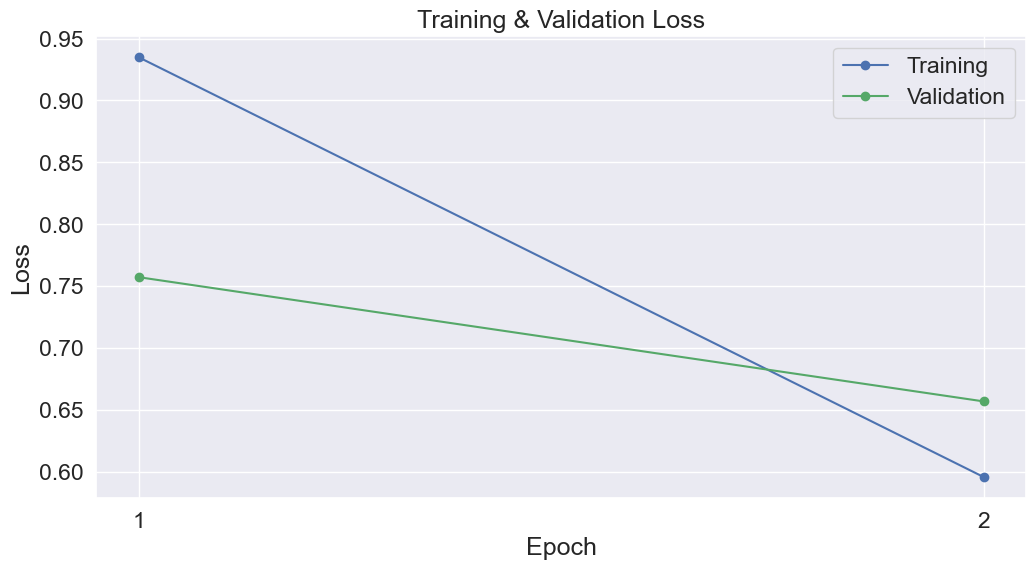

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2,])

plt.show()

13. Load and test the model.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    # print only the response and remove the question
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 Qual a velocidade da luz?

Response 1: 🤖 A velocidade da luz é de aproximadamente 186.282 milhas por segundo.
Response 2: 🤖 A velocidade da luz é de aproximadamente 186.282 milhas por segundo.


Done! 🤗